<h1 style="text-align:center; font-weight:bold; color:#2E86C1;">Introduction of Assimulo and CVODE</h1>
<h2 style="text-align:center;">Simulation Tools, 2026</h2>
<h3 style="text-align:center;">Liu-Di Lu</h3>

[CVODE](https://sundials.readthedocs.io/en/latest/cvode/Introduction_link.html) is a part of a C library called [SUite of Nonlinear and DIfferential/ALgebraic equation Solvers (SUNDIALS)](https://sundials.readthedocs.io/en/latest/index.html) developped Lawrence Livermore National Laboratory. 

[Assimulo](https://github.com/modelon-community/Assimulo) is a Cython/Python based simulation package that allows for simulation of ordinary differential equations.

### Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import assimulo.problem as apro
import assimulo.solvers as asol

Could not find cannot import name 'dopri5' from 'assimulo.lib' (/Users/lld/miniconda3/envs/assimulo/lib/python3.14/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/Users/lld/miniconda3/envs/assimulo/lib/python3.14/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/Users/lld/miniconda3/envs/assimulo/lib/python3.14/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


Do not be panic when you see these warnings :)

### Example

To illustrate how things work, we take the following second-order ODE:
$$\ddot x(t) - \mu(1-x^2(t))\dot x(t) + x(t) = a\sin(\omega t).$$
This is the so-called van der Pol oscillator. A brief introduction of this problem can be on the [Wikipedia webpage](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator). 

We first transform this second-order ODE into a first-order ODE system 
$$\left\{\begin{aligned}
\dot x_1(t) &= x_2(t),\\
\dot x_2(t) &= \mu(1-x_1^2(t))x_2(t) - x_1(t) + a\sin(\omega t),
\end{aligned}
\right.$$
where $x_1$ denotes the position and $x_2$ denotes the velocity.

We set the parameters: $\mu = 0.9$, $a = 1$, $\omega = 2$, and the initial conditions: $x(0) = 1$, $\dot x(0) = 1$. 

We can then define the right-hand side function.

In [5]:
mu = 0.9
a = 1
omega = 2

def vanderPol(t, x):
    xvec = np.zeros_like(x)
    xvec[0] = x[1]
    xvec[1] = mu * (1 - x[0]**2) * x[1] - x[0] + a * np.sin(omega * t)
    return xvec

Define the problem in Assimulo using the class Explicit_Problem, which requires the right-hand side, the initial point and the initial conditions.

In [6]:
vdP_Prolem = apro.Explicit_Problem(vanderPol, t0 = 0, y0 = np.array([1, 1]))
# vdP_Prolem.name = 'Van der Pol Oscillator'
vdP_Prolem.name = r'$\ddot x(t) - {mu}(1-x^2(t))\dot x(t) + x(t) = {a}\sin({omega} t)$'
vdP_Prolem.name = vdP_Prolem.name.format(mu=mu, a=a, omega=omega)

### CVode

Define a solver in Assimulo using CVode. 

<h5 style="text-align:center;">Please do not forget to reset your solver !!</h5>

Then we can solve our problem using *simulate(tfinal, ncp)* by providing the final time *tfinal* and number of communication points *ncp*. 

> ##### Some useful remarks

1. A communication point is a time point at which Assimulo stores and returns the solution to the user. It does not affect CVODE internal adaptive time stepping. CVODE may take many more or fewer internal steps, but you only see *ncp* points in the output. The idea of communication points corresponds to the $\Delta t_{\text{out}}$ in your first course.

2. The accuracy of CVODE can be controlled by the absolute tolerence value *atol* and the relative tolerence value *rtol*. Indeed, these two values together define the weight in the weighted norm (or the weighted error):
    
    $$\frac{|e_i|}{\text{atol}_i + \text{rtol}\,|x_i|}$$
    Roughly speaking, the absolute tolerence prevents error near zero explode especially for very small magnitude of solution $x_i$; and the relative tolerence limits the relative error. By default, both are $10^{-6}$. 

3. The default solver is BDF with order 1 to 5, which can be changed using the maximum order *maxord*. One can also switch the multistep solver to Adams using *discr*. In this case, the maximum order is 12.

In [19]:
vdP_Solver = asol.CVode(vdP_Prolem)
vdP_Solver.reset()
# vdP_Solver.rtol = 1e-4
# vdP_Solver.atol = 1e-4
# vdP_Solver.discr = 'ADAMS'
# vdP_Solver.maxord = 8
t_sol, x_sol = vdP_Solver.simulate(100, 1000)

Final Run Statistics: $\ddot x(t) - 0.9(1-x^2(t))\dot x(t) + x(t) = 1\sin(2 t)$ 

 Number of steps                                 : 2433
 Number of function evaluations                  : 3002
 Number of Jacobian evaluations                  : 42
 Number of function eval. due to Jacobian eval.  : 84
 Number of error test failures                   : 115
 Number of nonlinear iterations                  : 2999
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.06991292699240148 seconds.


We can also use our solver to plot the solution.

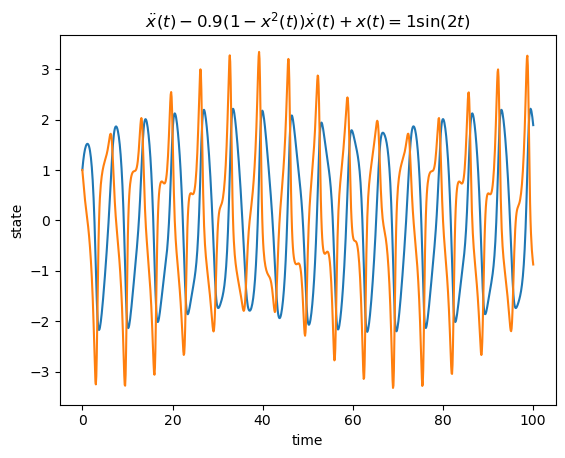

In [20]:
vdP_Solver.plot()

Like mentioned before, if we check our output x_sol, we will see that it only contains ncp points.

In [21]:
print(x_sol.shape)

(1001, 2)


We can also give the phase plot of our solutions $(x_1, x_2)$. Note that once again, this is related to the number of communication points thta you chose above.

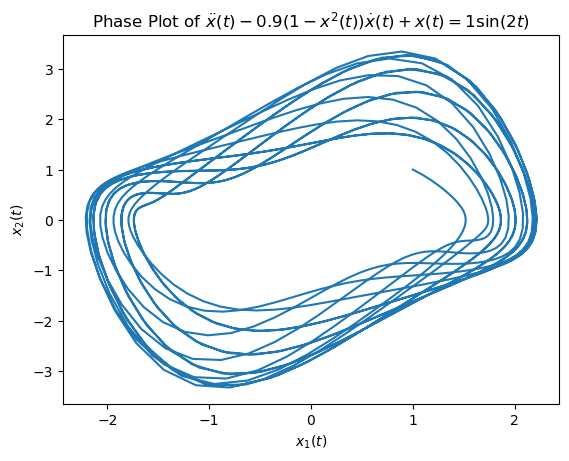

In [22]:
plt.figure()
plt.plot(x_sol[:,0], x_sol[:,1])
plt.title(f'Phase Plot of {vdP_Prolem.name}')
plt.xlabel(r'$x_1(t)$')
plt.ylabel(r'$x_2(t)$')
plt.show()

If we want to study the step size used in CVODE, we can set ncp to zero.

In [23]:
vdP_Solver.reset()
t_sol2, x_sol2 = vdP_Solver.simulate(100, 0)
# statistics = vdP_Solver.get_statistics().statistics

Final Run Statistics: $\ddot x(t) - 0.9(1-x^2(t))\dot x(t) + x(t) = 1\sin(2 t)$ 

 Number of steps                                 : 2433
 Number of function evaluations                  : 3002
 Number of Jacobian evaluations                  : 42
 Number of function eval. due to Jacobian eval.  : 84
 Number of error test failures                   : 115
 Number of nonlinear iterations                  : 2999
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.07010716199874878 seconds.


In particular, we can check the number of points in the output this time.

In [24]:
print(x_sol2.shape)

(2434, 2)


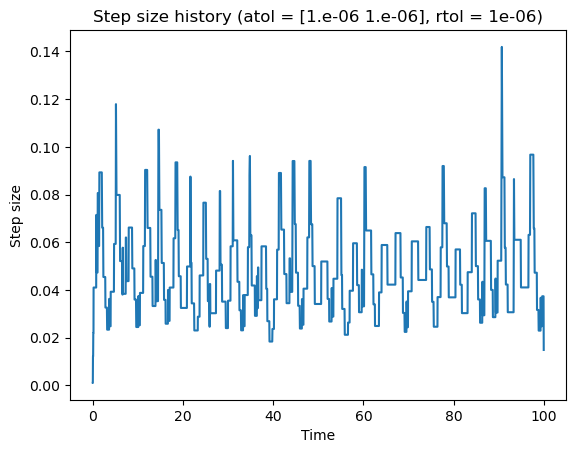

In [25]:
plt.figure()
plt.plot(t_sol2[:-1], np.diff(t_sol2))
plt.ylabel('Step size')
plt.xlabel('Time')
plt.title(f'Step size history (atol = {vdP_Solver.atol}, rtol = {vdP_Solver.rtol})')
plt.show()

### Explicit Euler

We can also use the build-in explicit Euler solver in Assimulo, which is *ExplicitEuler*. In this case, the step size is fixed, and set up as 0.01 by default.

In [33]:
vdP_EESolver = asol.ExplicitEuler(vdP_Prolem)
vdP_EESolver.reset()
# vdP_EESolver.h = 0.01
t_sol3, x_sol3 = vdP_EESolver.simulate(10)

Final Run Statistics: $\ddot x(t) - 0.9(1-x^2(t))\dot x(t) + x(t) = 1\sin(2 t)$ 


Solver options:

 Solver            : ExplicitEuler
 Solver type       : fixed step size
 Step size         : 0.01

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.07505179801955819 seconds.


Same way to plot the solution.

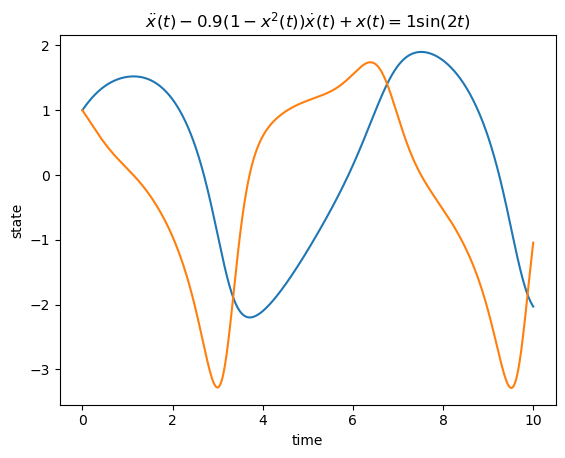

In [34]:
vdP_EESolver.plot()

In [28]:
print(x_sol3.shape)

(1002, 2)


### Implicit Euler

Instead of the explicit Euler method, there is also a build-in implicit Euler solver in Assimulo, which is *ImplicitEuler*. The step size is also set up to be 0.01 by default.

In [40]:
vdP_IESolver = asol.ImplicitEuler(vdP_Prolem)
vdP_IESolver.reset()
vdP_IESolver.h = 0.1
t_sol4, x_sol4 = vdP_IESolver.simulate(10)

Final Run Statistics: $\ddot x(t) - 0.9(1-x^2(t))\dot x(t) + x(t) = 1\sin(2 t)$ 

 Number of steps                                 : 101
 Number of function evaluations                  : 653
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 27
 Number of nonlinear iterations                  : 552
 Number of nonlinear convergence failures        : 6

Solver options:

 Solver            : ImplicitEuler
 Solver type       : fixed step size
 Step size         : 0.1

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.03374170802999288 seconds.


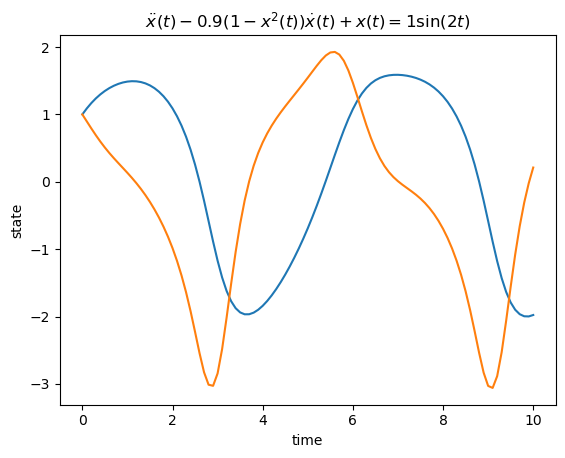

In [38]:
vdP_IESolver.plot()

### Design new class

The simplest way is to make a new class which inherits all from the existing one and only modifies some necessary part. For example, in Project 2, you need to define a new class *Explicit_Problem_2nd*. You can then use the exisiting class *Explicit_Problem*. An example looks like:

In [ ]:
class Explicit_Problem_2nd(apro.Explicit_Problem):
    def __init__(self, func, t0, y0, ydot0):
        
        # Define your wrapper here

        self.name = "2nd order explicit problem"

More information about the classes *Explicit_Problem* and *Explicit_ODE* can be found in [Assimulo GitHub repository](https://github.com/modelon-community/Assimulo), go to the *src* repository, then you have the file *problem.pyx* with the class *Explicit_Problem* defined inside, and the file *explicit_ode.pyx* with the class *Explicit_ODE* defined inside. Note that *problem.pyx* and *explicit_ode.pyx* are all cython implementation. 

<h3 style="text-align:center;">Please to arrive on time to the consultation session if you have any questions about the project<h3> 